In [21]:
### Don't mind about this 
import warnings
warnings.filterwarnings('ignore')
###
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
from sklearn.utils import shuffle
X_trining = pd.read_csv("training_features.txt")
Y_train = pd.read_csv("training_labels.txt")
X_test = pd.read_csv("test_features.txt")
Y_test = pd.read_csv("test_labels.txt")
X_trining['label']=Y_train
X_trining=shuffle(X_trining)
Y_train=X_trining['label']

In [23]:
X_train_arr= np.array(X_trining)
X_train_arr=X_train_arr[:,:-1]
X_test_arr= np.array(X_test)
Y_train_arr= np.array(Y_train)
Y_test_arr= np.array(Y_test)

In [24]:
def one_hot(Y):
    one_hot_y=np.zeros((Y.size, Y.max()))  
    one_hot_y[np.arange(Y.size), Y-1] = 1
    one_hot_y= one_hot_y.T
    return one_hot_y

In [25]:
class Layer:
    def sigmoid(self,z):
        return (1/(1+np.exp(-1*z)))

    def _diff_sigmoid(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))


    def _tanh(self, z):
        return np.tanh(z)

    def _diff_tanh(self, z):
        return 1-np.square(self._tanh(z))

    def relu(self,z):
        return np.maximum(0,z)

    def _diff_relu(self, z):
        a= np.zeros_like(z,dtype='int')
        a[z>0] = 1
        return a

    def softmax(self,z):
        exp = np.exp(z)
        tot= exp.sum(axis=0)
        t= exp/tot
        return t
    
    def _diff_softmax(self, z,y):
        yhat_r = self.softmax(z)
        one_yi = y *-1*(1-yhat_r)
        z=(1-y)*yhat_r
        return one_yi +z

    
    def __init__(self,n_neurons,n_inputs, activation='relu'):
        self.n_neurons = n_neurons #number of neurons 
        self.n_inputs = n_inputs #past number of samples
        self.activation_name = activation

        self.W= np.random.randn(self.n_neurons,self.n_inputs)*np.sqrt(2/self.n_inputs)
        self.b= np.random.randn(self.n_neurons,1)*np.sqrt(2/self.n_inputs)

        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
    
    def _set_target(self, t):
        self.target=t

    def forward(self,Ai):
        z = np.dot(self.W,Ai)+ self.b
        if (self.activation_name=='relu'):
            A = self.relu(z)
        elif(self.activation_name=='softmax'):
            A = self.softmax(z)
        else:
            A = self._tanh(z)
        self.Ai = Ai
        self.Z = z
        return A
    
    def backward(self,inp):
        if (self.activation_name=='relu'):
            act_diff = self._diff_relu(self.Z)
        elif(self.activation_name=='softmax'):
            act_diff = self._diff_softmax(self.Z,self.target)
        else:
            act_diff = self._diff_tanh(self.Z) 
        e = np.ones((self.Ai.shape[1],1))
        bet= inp * act_diff
        self.dW= self.dW+ np.dot(bet,self.Ai.T)
        self.db= self.db+ np.dot(bet,e)
        return np.dot(self.W.T, bet)
    
    def zeroing_diff(self):
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

In [29]:
class NN:
    def __init__(self,lr):
        self.alpha = lr
        self.layers = []
        self.t_loss=[]
        self.v_loss=[]

    def forward(self,X):
        a = X   
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self,inp):
        gd = inp
        for layer in self.layers[::-1]:
            gd = layer.backward(gd)
            
    def add_layer(self,n_neurons,n_inputs,act):
        self.layers.append(Layer(n_neurons,n_inputs,act))
    
    def loss(self, y_hat, y):
        onehotY= y
        yhat_r = np.max(onehotY*y_hat, axis=0,keepdims=True)
        return (1/(y.shape[1]))*-1*np.sum(np.log(yhat_r))
    
    def fit(self,x_train,y_train,x_val, y_val, epochs=5):
        M = x_train.shape[1]
        for i in range(epochs):
            y_hat = self.forward(x_train)       
            gd=self.loss(y_train, y_hat)
            print("Training loss: {}....".format(gd))
            self.t_loss.append(gd)
            self.layers[-1]._set_target(y_train)
            self.backward(1)   
            # apply GD
            for i in range(len(self.layers)):
                self.layers[i].W = self.layers[i].W - (self.alpha * (self.layers[i].dW/M))
                self.layers[i].b = self.layers[i].b - (self.alpha * (self.layers[i].db/M))
            
            y_hat_v = self.forward(x_val)
            gd=self.loss(y_val, y_hat_v)
            self.v_loss.append(gd)
            print("Validation loss: {}....".format(gd))
            print("-----------------------------------")       
            
                
            for layer in self.layers:
                layer.zeroing_diff()
        return self.t_loss, self.v_loss
                
    def predict(self,data): 
        y_hat= self.forward(data)
        return y_hat

In [35]:
def train_and_validate(model,X,Y_train_arr,n=3):
    skfolds = StratifiedKFold(n_splits=n)
    for train_index, test_index in skfolds.split(X,Y_train_arr):
        X_train_folds = np.array(X[train_index]).T
        y_train_folds = one_hot(np.array(Y_train_arr[train_index]).T)
        X_val_fold = np.array(X[test_index]).T
        y_val_fold = np.array(Y_train_arr[test_index])
        Y_val_arr_one_hot= one_hot(y_val_fold)
        train_loss , valid_loss = model.fit(X_train_folds,y_train_folds,X_val_fold,Y_val_arr_one_hot, epochs=750)
        Y_predicted = model.predict(X_val_fold)
        numbs=[]
        for i in range(len(y_val_fold)):
            s=np.argmax(Y_predicted[:,i])
            s+=1
            numbs.append(s)
    return train_loss,valid_loss

Training loss: 2.5374994383733256....
Validation loss: 2.5487260374819076....
-----------------------------------
Training loss: 2.5282529472522564....
Validation loss: 2.5399340300992783....
-----------------------------------
Training loss: 2.519244061107889....
Validation loss: 2.531358113121786....
-----------------------------------
Training loss: 2.510453963647212....
Validation loss: 2.5229723750498088....
-----------------------------------
Training loss: 2.5018643879623634....
Validation loss: 2.5147852534122204....
-----------------------------------
Training loss: 2.493479393734405....
Validation loss: 2.506776345919246....
-----------------------------------
Training loss: 2.4852961971321874....
Validation loss: 2.4989440964132865....
-----------------------------------
Training loss: 2.4772971859843365....
Validation loss: 2.491276008616149....
-----------------------------------
Training loss: 2.4694710996152445....
Validation loss: 2.483752644631275....
-----------------

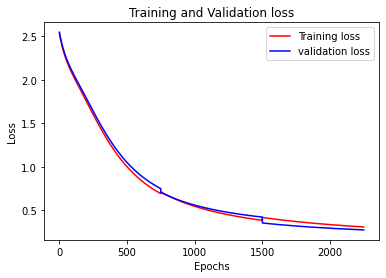

In [36]:
#training and validating
Classify_digits = NN(0.01)
Classify_digits.add_layer(50,256,'relu')
Classify_digits.add_layer(10,50,'softmax')
t_loss,v_loss= train_and_validate(Classify_digits,X_train_arr,Y_train_arr,n=3)
epochs = range(0,2250)
plt.plot(epochs, t_loss, 'r', label='Training loss')
plt.plot(epochs, v_loss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
def test(model,X):
    Xt=X.T
    Y_predicted = model.predict(Xt)
    numbs=[]
    for i in range(4999):
        s=np.argmax(Y_predicted[:,i])
        s+=1
        numbs.append(s)
    return classification_report(Y_test_arr, numbs)

X_test_arr= np.array(X_test)
report = test(Classify_digits,X_test_arr)
print(report)

              precision    recall  f1-score   support

           1       0.85      0.94      0.89       499
           2       0.90      0.89      0.90       500
           3       0.87      0.89      0.88       500
           4       0.89      0.92      0.91       500
           5       0.89      0.87      0.88       500
           6       0.93      0.93      0.93       500
           7       0.92      0.93      0.93       500
           8       0.86      0.80      0.83       500
           9       0.90      0.86      0.88       500
          10       0.96      0.94      0.95       500

    accuracy                           0.90      4999
   macro avg       0.90      0.90      0.90      4999
weighted avg       0.90      0.90      0.90      4999



In [38]:
def distortion(distortion_level, data, n_samples):
    x=data
    pixels_sz= int(distortion_level*256)
    for s in range(n_samples):
        pixels= np.random.randint(256, size=pixels_sz)
        for i in pixels:
            x[s,i]= int(np.random.randint(2, size=1))
    return x

In [39]:
#Distortion 0.2
xtr1= distortion(0.2,X_train_arr,X_train_arr.shape[0])
xtest1=distortion(0.2,X_test_arr, X_test_arr.shape[0])
C1 = NN(0.01)
C1.add_layer(50,256,'relu')
C1.add_layer(10,50,'softmax')
t_loss,v_loss= train_and_validate(C1,xtr1,Y_train_arr,n=3)
report1 = test(C1,xtest1)
print(report1)

Training loss: 2.5938830349422948....
Validation loss: 2.589044313585624....
-----------------------------------
Training loss: 2.5842696214922145....
Validation loss: 2.580062586061082....
-----------------------------------
Training loss: 2.5749861658388795....
Validation loss: 2.5713840145858993....
-----------------------------------
Training loss: 2.566015641084627....
Validation loss: 2.562973681709582....
-----------------------------------
Training loss: 2.557326466240563....
Validation loss: 2.5548191758015864....
-----------------------------------
Training loss: 2.5489186837463094....
Validation loss: 2.546915916346295....
-----------------------------------
Training loss: 2.5407885737325517....
Validation loss: 2.53924927490594....
-----------------------------------
Training loss: 2.5329100711648382....
Validation loss: 2.531795474627491....
-----------------------------------
Training loss: 2.5252570065149027....
Validation loss: 2.524551616697042....
--------------------

In [40]:
#Distortion 0.5
xtr2= distortion(0.5,X_train_arr,X_train_arr.shape[0])
xtest2=distortion(0.5,X_test_arr,X_test_arr.shape[0])
C2 = NN(0.01)
C2.add_layer(50,256,'relu')
C2.add_layer(10,50,'softmax')
t_loss,v_loss= train_and_validate(C2,xtr2,Y_train_arr,n=3)
report2 = test(C2,xtest2)
print(report2)

Training loss: 2.5880221476479988....
Validation loss: 2.5909792554724462....
-----------------------------------
Training loss: 2.574783695951101....
Validation loss: 2.579001004614071....
-----------------------------------
Training loss: 2.562541083867856....
Validation loss: 2.5679524982031645....
-----------------------------------
Training loss: 2.551233105532015....
Validation loss: 2.557684220361112....
-----------------------------------
Training loss: 2.540708443831499....
Validation loss: 2.548143060347563....
-----------------------------------
Training loss: 2.5309122716151116....
Validation loss: 2.539267840999017....
-----------------------------------
Training loss: 2.5217948116129087....
Validation loss: 2.530981560619638....
-----------------------------------
Training loss: 2.5132666415436202....
Validation loss: 2.5232092937423762....
-----------------------------------
Training loss: 2.5052662511794934....
Validation loss: 2.515912882975651....
--------------------

In [41]:
#Distortion 0.9
xtr3= distortion(0.9,X_train_arr,X_train_arr.shape[0])
xtest3=distortion(0.9,X_test_arr,X_test_arr.shape[0])
C3 = NN(0.01)
C3.add_layer(50,256,'relu')
C3.add_layer(10,50,'softmax')
t_loss,v_loss= train_and_validate(C3,xtr3,Y_train_arr,n=3)
report3 = test(C3,xtest3)
print(report3)

Training loss: 2.6380931014088485....
Validation loss: 2.603681316139521....
-----------------------------------
Training loss: 2.613104860718649....
Validation loss: 2.582746703027099....
-----------------------------------
Training loss: 2.5921795203520004....
Validation loss: 2.565037816584401....
-----------------------------------
Training loss: 2.5744183080323033....
Validation loss: 2.5497655532099115....
-----------------------------------
Training loss: 2.559138158879592....
Validation loss: 2.5365873311102862....
-----------------------------------
Training loss: 2.545947885553299....
Validation loss: 2.525100028474145....
-----------------------------------
Training loss: 2.53440665071078....
Validation loss: 2.5149813394005585....
-----------------------------------
Training loss: 2.524189379294166....
Validation loss: 2.506058891808003....
-----------------------------------
Training loss: 2.515158955653528....
Validation loss: 2.498099498035612....
-----------------------